Principal Components Analysis

1. Imports

In [1]:
import pandas as pd
import numpy as np
import random as rd
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt

2. Create data

In [10]:
genes = ['gene' + str(i) for i in range(1, 101)]

wt = ['wt' + str(i) for i in range(1, 6)]
ko = ['ko' + str(i) for i in range(1, 6)]

data = pd.DataFrame(columns=[*wt, *ko], index=genes)

for gene in data.index:
  data.loc[gene, 'wt1':'wt5'] = np.random.poisson(lam=rd.randrange(10, 1000), size=5)
  data.loc[gene, 'ko1':'ko5'] = np.random.poisson(lam=rd.randrange(10, 1000), size=5)


print(data.shape)
print(data.head())

(100, 10)
       wt1  wt2  wt3  wt4  wt5  ko1  ko2  ko3  ko4  ko5
gene1  787  821  839  826  837  952  909  984  939  952
gene2  403  375  394  393  383  650  623  625  639  631
gene3  455  502  514  515  498   87   65   94   79   79
gene4  636  635  636  622  619  337  337  384  324  360
gene5  828  870  816  808  819  107  122  109  103   98


3. Preprocessing

In [11]:
scaled_data = preprocessing.scale(data.T)



4. PCA

In [14]:
pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

5. Scree plot

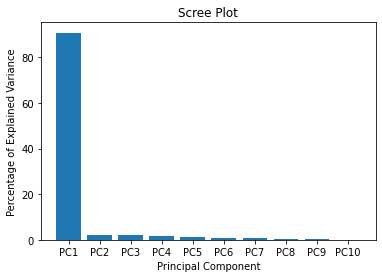

In [17]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

plt.bar(x=range(1, len(per_var) + 1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

6. Scatter plot

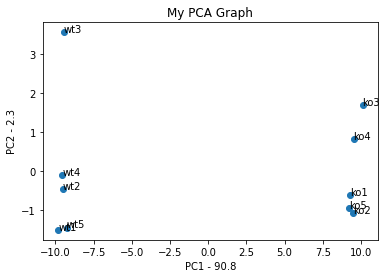

In [20]:
pca_df = pd.DataFrame(pca_data, index=[*wt, *ko], columns=labels)

plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA Graph')
plt.xlabel(f'PC1 - {per_var[0]}')
plt.ylabel(f'PC2 - {per_var[1]}')

for sample in pca_df.index:
  plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

plt.show()

In [21]:
loading_scores = pd.Series(pca.components_[0], index=genes)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

top_10_genes = sorted_loading_scores[0:10].index.values

print(loading_scores[top_10_genes])

gene19   -0.104932
gene29    0.104909
gene13    0.104898
gene17   -0.104878
gene27    0.104871
gene66    0.104868
gene76   -0.104868
gene49   -0.104860
gene56   -0.104849
gene43   -0.104845
dtype: float64
